## Import the Libraries

In [1]:
import pandas as pd
import dowhy as dy

## Load the data

In [2]:
raw_data = pd.read_csv("owid-covid-data.csv")
raw_data.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'total_tests', 'new_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'tests_per_case', 'positive_rate', 'tests_units', 'stringency_index',
       'population', 'population_density', 'median_age', 'aged_65_older',
       'aged_70_older', 'gdp_per_capita', 'extreme_poverty',
       'cardiovasc_death_r

In [3]:
raw_data[raw_data.location == 'New Zealand']['total_deaths_per_million']

39308      NaN
39309      NaN
39310      NaN
39311      NaN
39312      NaN
         ...  
39621    5.184
39622    5.184
39623    5.184
39624    5.184
39625    5.184
Name: total_deaths_per_million, Length: 318, dtype: float64

## Get the date of first case reported 

In [4]:
## Convert the date column to be in the form of day, month, year.
df = raw_data.copy()
df['date']= pd.to_datetime(df['date'], infer_datetime_format=True)
#df = df.dropna(subset=['stringency_index','total_deaths_per_million'])
df = df.dropna(subset=['stringency_index'])


In [5]:
list_of_countries = df.location.unique()
print("There are {} unique country names in the dataset".format(len(list_of_countries)))

There are 181 unique country names in the dataset


In [6]:
#drop the world and international rows 
countries_df = df.copy()
countries_df = countries_df.drop(df[df['location'].isin(['World','International'])].index, axis =0)

In [7]:
list_of_countries = countries_df.location.unique()

In [8]:
list_of_countries = list(list_of_countries)

### Calculate the date for first covid case per country

In [9]:
#def get_first_date_for_an_event(data, list_of_countries, column_of_interest):
import numpy as np
dates_of_first_case = []
dates_of_index_40 = []
countries = []
total_deaths_per = []
for i in list_of_countries:
    cases_indeces = countries_df[countries_df['location']== i][['date','new_cases','stringency_index','total_deaths_per_million']]
    firs_case_date = min(cases_indeces[cases_indeces.new_cases != 0]['date'])
    total_deaths_per_updated = cases_indeces['total_deaths_per_million'].max(skipna = True)
    try:
        date_of_index_40 = min(cases_indeces[cases_indeces.stringency_index >= 40]['date'])
        dates_of_index_40.append(date_of_index_40)
        dates_of_first_case.append(firs_case_date)
        total_deaths_per.append(total_deaths_per_updated)
        countries.append(i)
    except ValueError as e:
        j = max(cases_indeces['stringency_index'])
        print("Country {} had an index of {}lockdown measures".format(i,j))
#all_cases_dates = aruba_cases.new_cases    

Country Burundi had an index of 14.81lockdown measures
Country Belarus had an index of 22.22lockdown measures
Country Nicaragua had an index of 16.67lockdown measures
Country Taiwan had an index of 30.56lockdown measures


In [10]:
list_dates = list(zip(countries,dates_of_first_case, dates_of_index_40,total_deaths_per))


In [11]:
all_countries = pd.DataFrame(list_dates, columns=['Country_Name','First_case_of_covid','stringency_index_date','total_deaths_per_million'])
all_countries = all_countries.dropna()
all_countries['Delta_days'] = (all_countries['stringency_index_date'] - all_countries['First_case_of_covid']).dt.days
data = all_countries

## Verify that dates were capture correctly. 

In [12]:
#new_zealand had the first case on 2020-02-28
data[data['Country_Name']== 'New Zealand']

,Country_Name,First_case_of_covid,stringency_index_date,total_deaths_per_million,Delta_days
120,New Zealand,2020-02-28,2020-03-21,5.184,22


In [13]:
data = pd.DataFrame(data=
                    {
                     'total_deaths_per_million': data['total_deaths_per_million'],
                     'Delta_days': data['Delta_days']
                     }
                   )

In [14]:
model= dy.CausalModel(
    data = data,
    treatment = 'Delta_days',
    outcome = 'total_deaths_per_million',
    graph = """graph[directed 1 node[id "Delta_days" label "Delta_days"]
                node[id "total_deaths_per_million" label "total_deaths_per_million"]
                edge[source "Delta_days" target "total_deaths_per_million"]]"""
                )


INFO:dowhy.causal_graph:If this is observed data (not from a randomized experiment), there might always be missing confounders. Adding a node named "Unobserved Confounders" to reflect this.
INFO:dowhy.causal_model:Model to find the causal effect of treatment ['Delta_days'] on outcome ['total_deaths_per_million']


INFO:dowhy.causal_graph:Using Matplotlib for plotting


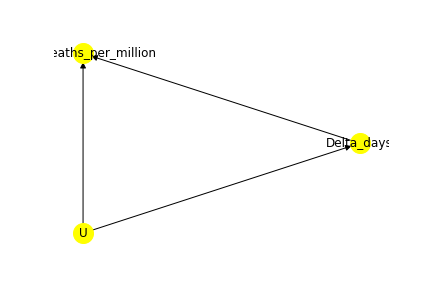

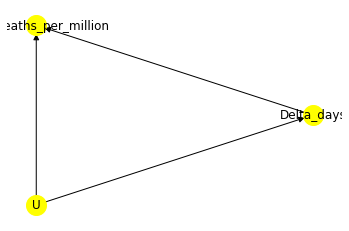

In [15]:

from IPython.display import Image, display
model.view_model()
display(Image(filename="causal_model.png"))

In [16]:
identified_estimand = model.identify_effect()


INFO:dowhy.causal_identifier:Common causes of treatment and outcome:['U']
INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:[]


In [17]:
print(identified_estimand)


Estimand type: nonparametric-ate
### Estimand : 1
Estimand name: backdoor
Estimand expression:
    d                                           
─────────(Expectation(total_deaths_per_million))
d[Δ_days]                                       
Estimand assumption 1, Unconfoundedness: If U→{Delta_days} and U→total_deaths_per_million then P(total_deaths_per_million|Delta_days,,U) = P(total_deaths_per_million|Delta_days,)
### Estimand : 2
Estimand name: iv
No such variable found!



In [18]:
estimate = model.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")
print(estimate)

INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: total_deaths_per_million~Delta_days
                               OLS Regression Results                               
Dep. Variable:     total_deaths_per_million   R-squared:                       0.030
Model:                                  OLS   Adj. R-squared:                  0.024
Method:                       Least Squares   F-statistic:                     4.962
Date:                      Sun, 15 Nov 2020   Prob (F-statistic):             0.0273
Time:                              23:23:59   Log-Likelihood:                -1130.1
No. Observations:                       163   AIC:                             2264.
Df Residuals:                           161   BIC:                             2270.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
               

In [19]:
from dowhy.causal_refuters.placebo_treatment_refuter import PlaceboTreatmentRefuter
refuter = PlaceboTreatmentRefuter(data=data, identified_estimand=identified_estimand, estimate=estimate, placebo_type='permute')
print(refuter.refute_estimate())

lion   R-squared:                       0.001
Model:                                  OLS   Adj. R-squared:                 -0.006
Method:                       Least Squares   F-statistic:                   0.08684
Date:                      Sun, 15 Nov 2020   Prob (F-statistic):              0.769
Time:                              23:24:39   Log-Likelihood:                -1132.6
No. Observations:                       163   AIC:                             2269.
Df Residuals:                           161   BIC:                             2275.
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        177.5678     26.655      6.662      0.000     124.929     230.206
x1             0.3459      1.174     